<b>Problem</b>: The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

<b>Dataset</b>: Same as Notebook -- 1. Load and Explore Household Energy Usage Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Load all data
dataset = pd.read_csv(
    filepath_or_buffer='Data/household_power_consumption.txt',
    sep=';', header=0,low_memory=False, na_values='?',
    parse_dates={'datetime':[0,1]}, index_col=['datetime'],
    dtype={
        'Global_active_power' : np.float64,
        'Global_reactive_power' : np.float64,
        'Voltage' : np.float64,
        'Global_intensity' : np.float64,
        'Sub_metering_1' : np.float64,
        'Sub_metering_2' : np.float64,
        'Sub_metering_3' : np.float64
    }
)
print(dataset.shape)
print(dataset.head())

(2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28

In [3]:
# Fill missing values with a value at the same time previous day or any other day
def fill_missing(values, days_ago):
    period = int(days_ago) * 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - period, col]

In [4]:
# fill missing
fill_missing(values=dataset.values, days_ago=1)

In [5]:
dataset.loc[np.isnan(dataset.Sub_metering_1)]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,


In [6]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
# example of resmapling and aggregation
daily_groups = dataset.resample('D').sum()
daily_groups

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-12-07,1109.574,285.912,345914.85,4892.0,1724.0,646.0,6444.0
2010-12-08,529.698,169.098,346744.70,2338.2,0.0,514.0,3982.0
2010-12-09,1612.092,201.358,347932.40,6848.2,1805.0,2080.0,8891.0


### Evaluation Metric
1. Root mean squared error (RMSE)
2. Mean absolute error (MAE)
3. Mean squared error (MSE) (but not in the same unit as input)

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [9]:
# Train and Test Sets
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[2:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train) / 7))
    test = np.array(np.split(test, len(test) / 7))
    return train, test

In [10]:
# split into train and test
train, test = split_dataset(daily_groups.values)
print(type(train))
print(len(train))
print(train.shape)
print(len(test))
print(test.shape)

<class 'numpy.ndarray'>
161
(161, 7, 7)
46
(46, 7, 7)


In [11]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

# week one year ago persistence model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

In [12]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    mse_all = mean_squared_error(actual, predicted)
    score = np.sqrt(mse_all)
    return score, scores

In [13]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [14]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = np.array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

daily: [721.228] 758.3, 726.1, 686.2, 622.5, 693.0, 755.9, 793.0
weekly: [803.192] 863.1, 809.6, 771.4, 678.0, 829.4, 862.5, 793.0
week-oya: [590.741] 610.3, 568.9, 561.7, 555.9, 539.2, 646.7, 642.8


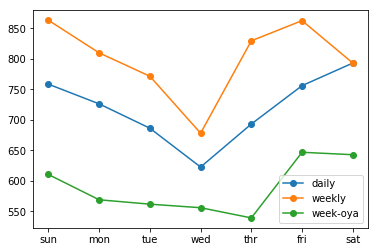

In [15]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence

# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(days, scores, marker='o', label=name)
# show plot
plt.legend()
plt.show()